# 爬虫

## 基于requests的单线程爬虫

In [ ]:
from crawler.news import NewsCrawler
crawler = NewsCrawler()

In [ ]:
crawler.crawl()

In [ ]:
crawler.save_data('data/cn')

## 基于Scrapy的并发爬虫

Scrapy 是一个非常强大的 Python 框架，用于 Web 爬虫和数据抓取。它可以轻松地爬取网站上的数据，并将其存储在所需的格式中（如 CSV、JSON 或数据库）。

首先在项目根目录下创建名为`news_crawler`的Scrapy爬虫项目

```bash
scrapy startproject news_crawler
```

生成一个爬虫模板，稍后按本实验的需求修改：

```bash
scrapy genspider example quotes.toscrape.com
```

### 爬取中文数据
通过Scrapy框架运行爬虫：

```bash
cd news_crawler
scrapy crawl news_spider -s CLOSESPIDER_ITEMCOUNT=10000 -s OUTPUT_DIR="../data/cn" -a language="cn" -a start_keyword="新闻"
```

### 爬取英文数据
通过Scrapy框架运行爬虫，只是更换语言即可：

```bash
cd news_crawler
scrapy crawl news_spider -s CLOSESPIDER_ITEMCOUNT=10000 -s OUTPUT_DIR="../data/en" -a language="en" -a start_keyword="China"
```

# 数据处理

## 去除乱码

In [37]:
import json
from tqdm import tqdm

def wash_cn(text: str) -> str:
    cleaned_text = ''
    for char in text:
        if ('\u4e00' <= char <= '\u9fff' or  # 中文汉字
            # '\u3000' <= char <= '\u303f' or  # 中文标点符号
            '\u3400' <= char <= '\u4dbf' ):  # 扩展汉字
            # '\u0030' <= char <= '\u0039'   # 阿拉伯数字
            # '\uff00' <= char <= '\uffef'# 全角字符和标点
            cleaned_text += char
    
    return cleaned_text

with open('data/cn/data.json', 'r') as f:
    data = json.load(f)
    
for news in tqdm(data):
    news['content'] = wash_cn(news['content'])
    
with open('data/cn/washed.json', 'w') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|██████████| 5024/5024 [00:00<00:00, 7958.34it/s]


In [26]:
import json
from tqdm import tqdm

def wash_en(text: str) -> str:
    cleaned_text = ''
    parts = text.split('#')
    text = text if len(parts) == 1 else '#'.join(parts[:-1]).strip()
    
    for char in text:
        if '\u0020' <= char <= '\u007e': # 英文字符和常见标点
            cleaned_text += char
            
    return cleaned_text

with open('data/en/data.json', 'r') as f:
    data = json.load(f)
    
for news in tqdm(data):
    news['content'] = wash_en(news['content'])
    
with open('data/en/washed.json', 'w') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

  0%|          | 0/924 [00:00<?, ?it/s]

100%|██████████| 924/924 [00:00<00:00, 8737.21it/s]


## 分词

### 中文分词
使用jieba分词，全部文本储存在`data/cn/tokenized.txt`中。

In [38]:
import json
import jieba
from tqdm import tqdm

def tokenize_cn(contents: list[dict[str, str]]) -> list[str]:
    tokenized_results = []
    for content in tqdm(contents):
        words = jieba.lcut(content['content'])
        tokenized_results.extend(words)
    return tokenized_results

with open('data/cn/washed.json', 'r') as f:
    data = json.load(f)
    tokenized_results = tokenize_cn(data)
    
with open('data/cn/tokenized.json', 'w') as f:
    json.dump(tokenized_results, f, ensure_ascii=False, indent=4)

100%|██████████| 5024/5024 [00:26<00:00, 192.33it/s]


### 英文分词

In [43]:
import json
from tqdm import tqdm

def tokenize_en(contents: list[dict[str, str]]) -> list[str]:
    tokenized_results = []
    for content in tqdm(contents):
        words = content['content'].split()
        tokenized_results.extend(words)
    return tokenized_results

with open('data/en/washed.json', 'r') as f:
    data = json.load(f)
    tokenized_results = tokenize_en(data)
    
with open('data/en/tokenized.json', 'w') as f:
    json.dump(tokenized_results, f, ensure_ascii=False, indent=4)

  0%|          | 0/924 [00:00<?, ?it/s]

100%|██████████| 924/924 [00:00<00:00, 45342.24it/s]


# 提取日期

In [47]:
import re
from tqdm import tqdm

def extract_date(text: str) -> list[str]:
    # 使用非捕获组 (?:) 避免捕获分隔符，如 "年", "月", "日"
    patterns = [
        r'\d{4}(?:年|-|/)\d{1,2}(?:月|-|/)\d{1,2}(?:日)?',  # 完整日期：YYYY-MM-DD
        r'\d{4}(?:年|-|/)\d{1,2}(?:月)?',                    # 年月：YYYY-MM
        r'\d{1,2}(?:月|-|/)\d{1,2}(?:日)?'                   # 月日：MM-DD
    ]
    
    dates = []
    for pattern in patterns:
        matches = re.findall(pattern, text)
        dates.extend(matches)
    return dates

with open('data/cn/data.json', 'r') as f:
    data = json.load(f)
    tokenized_results = tokenize_cn(data)
    
dates = []
for news in tqdm(data):
    dates.extend(extract_date(news['content']))

with open('data/cn/dates.json', 'w') as f:
    json.dump(dates, f, ensure_ascii=False, indent=4)

  0%|          | 0/5024 [00:00<?, ?it/s]

100%|██████████| 5024/5024 [00:00<00:00, 19463.79it/s]


# 验证Chef定律

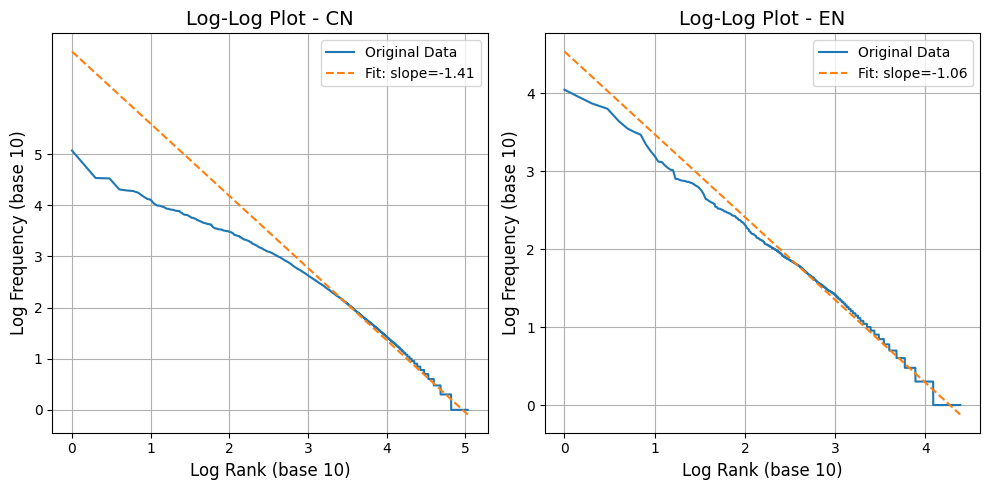

In [44]:
# Import necessary modules
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load the tokenized JSON files for Chinese and English words
cn_file_path = 'data/cn/tokenized.json'
en_file_path = 'data/en/tokenized.json'

with open(cn_file_path, 'r', encoding='utf-8') as cn_file:
    cn_words = json.load(cn_file)

with open(en_file_path, 'r', encoding='utf-8') as en_file:
    en_words = json.load(en_file)

# Count the frequency of each word
cn_word_freq = Counter(cn_words)
en_word_freq = Counter(en_words)

# Sort the word frequencies in descending order
sorted_cn_freq = sorted(cn_word_freq.items(), key=lambda x: x[1], reverse=True)
sorted_en_freq = sorted(en_word_freq.items(), key=lambda x: x[1], reverse=True)

# Get the rank (position) and frequency for Chinese and English words
cn_ranks = np.arange(1, len(sorted_cn_freq) + 1)
cn_frequencies = np.array([freq for word, freq in sorted_cn_freq])

en_ranks = np.arange(1, len(sorted_en_freq) + 1)
en_frequencies = np.array([freq for word, freq in sorted_en_freq])

# Convert rank and frequency to log scale
log_cn_ranks = np.log10(cn_ranks)
log_cn_frequencies = np.log10(cn_frequencies)

log_en_ranks = np.log10(en_ranks)
log_en_frequencies = np.log10(en_frequencies)

# Fit a linear model (for log-transformed data)
cn_fit = np.polyfit(log_cn_ranks, log_cn_frequencies, 1)
en_fit = np.polyfit(log_en_ranks, log_en_frequencies, 1)

# Generate the fitted lines
fitted_cn_frequencies = cn_fit[0] * log_cn_ranks + cn_fit[1]
fitted_en_frequencies = en_fit[0] * log_en_ranks + en_fit[1]

# Plotting log-log data and linear fits on a regular linear scale
plt.figure(figsize=(10, 5))

# Chinese words subplot
plt.subplot(1, 2, 1)
plt.plot(log_cn_ranks, log_cn_frequencies, label='Original Data')
plt.plot(log_cn_ranks, fitted_cn_frequencies, linestyle='--', label=f'Fit: slope={cn_fit[0]:.2f}')
plt.title("Log-Log Plot - CN", fontsize=14)
plt.xlabel("Log Rank (base 10)", fontsize=12)
plt.ylabel("Log Frequency (base 10)", fontsize=12)
plt.xticks(np.arange(int(min(log_cn_ranks)), int(max(log_cn_ranks)) + 1, 1))  # Set x-axis ticks
plt.yticks(np.arange(int(min(log_cn_frequencies)), int(max(log_cn_frequencies)) + 1, 1))  # Set y-axis ticks
plt.legend()
plt.grid(True)

# English words subplot
plt.subplot(1, 2, 2)
plt.plot(log_en_ranks, log_en_frequencies, label='Original Data')
plt.plot(log_en_ranks, fitted_en_frequencies, linestyle='--', label=f'Fit: slope={en_fit[0]:.2f}')
plt.title("Log-Log Plot - EN", fontsize=14)
plt.xlabel("Log Rank (base 10)", fontsize=12)
plt.ylabel("Log Frequency (base 10)", fontsize=12)
plt.xticks(np.arange(int(min(log_en_ranks)), int(max(log_en_ranks)) + 1, 1))  # Set x-axis ticks
plt.yticks(np.arange(int(min(log_en_frequencies)), int(max(log_en_frequencies)) + 1, 1))  # Set y-axis ticks
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
